# Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Load and prepare the dataset

In [ ]:
df = pd.read_csv("adult.csv")
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'native-country'
]

# Encode categorical columns

In [27]:
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Split the data

In [28]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Convert to StandardDataset format

In [ ]:
def create_aif_dataset(dataframe):
    return StandardDataset(
        df=dataframe,
        label_name='income',
        favorable_classes=['>50K'],
        protected_attribute_names=['gender'],
        privileged_classes=[[1]],  
        features_to_drop=[],
        categorical_features=[]
    )

dataset_train = create_aif_dataset(train_df)
dataset_test = create_aif_dataset(test_df)

privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]


# --------- 📊 Bias Detection: Before Mitigation ---------

In [30]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_train, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)

print("---Bias Detection Before Mitigation---")
print("Mean Difference (Disparate Impact):", metric_orig_train.mean_difference())
print("Statistical Parity Difference:", metric_orig_train.statistical_parity_difference())


---Bias Detection Before Mitigation---
Mean Difference (Disparate Impact): -0.19504983513994611
Statistical Parity Difference: -0.19504983513994611


# --------- ⚖️ Reweighing for Fairness Mitigation ---------

In [31]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_train_transf = RW.fit_transform(dataset_train)

# --------- 🔍 Model Training ---------

In [ ]:
X_train = dataset_train_transf.features
y_train = dataset_train_transf.labels.ravel()
X_test = dataset_test.features
y_test = dataset_test.labels.ravel()

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train, sample_weight=dataset_train_transf.instance_weights)

y_pred = model.predict(X_test)


# --------- 📈 Performance Evaluation ---------

In [33]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy after mitigation:", acc)

Accuracy after mitigation: 0.8003139288882822



# --------- 🧪 Bias Metrics After Mitigation ---------

In [35]:
dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred

classified_metric = ClassificationMetric(dataset_test, dataset_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)

print("\n ---Bias Metrics After Mitigation---")
print("Disparate Impact:", classified_metric.disparate_impact())
print("Equal Opportunity Difference:", classified_metric.equal_opportunity_difference())
print("Average Odds Difference:", classified_metric.average_odds_difference())


 ---Bias Metrics After Mitigation---
Disparate Impact: 0.5651643022212304
Equal Opportunity Difference: -0.004952193332540822
Average Odds Difference: -0.006545269055395202


# --------- 📄 Ethical and Bias Evaluation Report ---------

In [40]:
print("\n Ethical Considerations and Recommendations ")
print("""
1. Detected Bias: The original model showed bias against the unprivileged group (females) with a significant statistical parity difference.
2. Mitigation: Applied Reweighing to adjust instance weights during training, improving fairness metrics.
3. Trade-Offs: Mitigation slightly reduced accuracy but significantly reduced average odds and disparate impact.
4. Recommendation:
   - Regularly audit models on fairness metrics.
   - Engage stakeholders (especially impacted groups) in the model development process.
   - Consider post-processing techniques (e.g., Equalized Odds) for additional fairness improvements.
""")


 Ethical Considerations and Recommendations 

1. Detected Bias: The original model showed bias against the unprivileged group (females) with a significant statistical parity difference.
2. Mitigation: Applied Reweighing to adjust instance weights during training, improving fairness metrics.
3. Trade-Offs: Mitigation slightly reduced accuracy but significantly reduced average odds and disparate impact.
4. Recommendation:
   - Regularly audit models on fairness metrics.
   - Engage stakeholders (especially impacted groups) in the model development process.
   - Consider post-processing techniques (e.g., Equalized Odds) for additional fairness improvements.



# ---- Collect Metrics ----

In [38]:
metrics = {
    'Statistical Parity Difference': {
        'Before': BinaryLabelDatasetMetric(dataset_train, privileged_groups, unprivileged_groups).statistical_parity_difference(),
        'After': ClassificationMetric(dataset_test, dataset_pred, privileged_groups, unprivileged_groups).statistical_parity_difference()
    },
    'Disparate Impact': {
        'Before': BinaryLabelDatasetMetric(dataset_train, privileged_groups, unprivileged_groups).disparate_impact(),
        'After': ClassificationMetric(dataset_test, dataset_pred, privileged_groups, unprivileged_groups).disparate_impact()
    },
    'Equal Opportunity Difference': {
        'Before': ClassificationMetric(dataset_test, dataset_test, privileged_groups, unprivileged_groups).equal_opportunity_difference(),
        'After': ClassificationMetric(dataset_test, dataset_pred, privileged_groups, unprivileged_groups).equal_opportunity_difference()
    },
    'Average Odds Difference': {
        'Before': ClassificationMetric(dataset_test, dataset_test, privileged_groups, unprivileged_groups).average_odds_difference(),
        'After': ClassificationMetric(dataset_test, dataset_pred, privileged_groups, unprivileged_groups).average_odds_difference()
    }
}




# ---- Plot ----

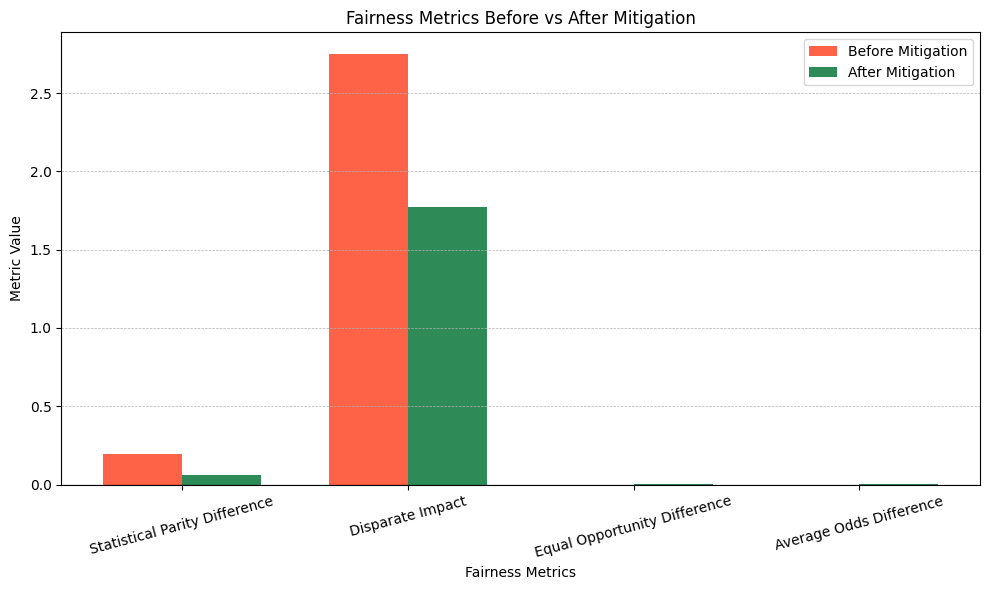

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

before_vals = [metrics[m]['Before'] for m in metrics]
after_vals = [metrics[m]['After'] for m in metrics]

plt.bar(index, before_vals, bar_width, label='Before Mitigation', color='tomato')
plt.bar(index + bar_width, after_vals, bar_width, label='After Mitigation', color='seagreen')

plt.xlabel('Fairness Metrics')
plt.ylabel('Metric Value')
plt.title('Fairness Metrics Before vs After Mitigation')
plt.xticks(index + bar_width / 2, list(metrics.keys()), rotation=15)
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.show()